# Targeted attacks
Here we take inspiration fro chen2020 proofs, and we try to recreate the same difficult scenario they presented. IN general fro any substructure which is not a clique we can always find two nodes, say $\{1,2\}$ such that $(1,2) \notin E$. Therefpore we can create two graphs which have different nuber of counts but are impossible to distinguish from the Weistfeiler-Lehman test.

In particular, the first graph is simply a collection of disconneted sunbstructures with the edge $(1,2)$ added, hence in this case the count of induced substructures is 0, while in the secon case we link all the substructures with additional edges with endpoints the equivalnet of $1! and $2$ in the relatice sibstructure

**REMARK**: these graphs can be generated with any kind of substructure and in any size (by simply connecting the in a circle all the substructures)

In [1]:
# imports
import os
import sys
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))
cwd = os.path.dirname(os.getcwd())

import networkx as nx
import dgl
import torch
from networkx.generators import random_regular_graph, gnp_random_graph
from torch.utils.data import DataLoader
import tqdm
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from src.dataset.counting_algorithm import subgraph_counting
from src.dataset.graph_permutation import GraphPermutation
from src.lrp.dataset_synthetic import DglSyntheticDataset, collate_lrp_dgl_light
from src.lrp.model_synthetic import LRP_synthetic

In [2]:
def np_sparse_to_pt_sparse(matrix):
    coo = matrix.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

def build_perm_pooling_sp_matrix(split_list, pooling = "sum"):
    dim0, dim1 = len(split_list), sum(split_list)
    col = np.arange(dim1)
    row = np.array([i for i, count in enumerate(split_list) for j in range(count)])
    data = np.ones((dim1, ))
    pooling_sp_matrix = csr_matrix((data, (row, col)), shape = (dim0, dim1))

    if pooling == "mean":
        pooling_sp_matrix = normalize(pooling_sp_matrix, norm='l1', axis=1)
    
    return np_sparse_to_pt_sparse(pooling_sp_matrix)

# 2 tailed triangles

We start with the example showed in picture (2) of the paper were the created two graphs as descripted above with 2 tailed triangles motifs. We can see that LRP fails to count the substructures in the second graphs. Hence this kind of permutation seem to be an effective target attack.

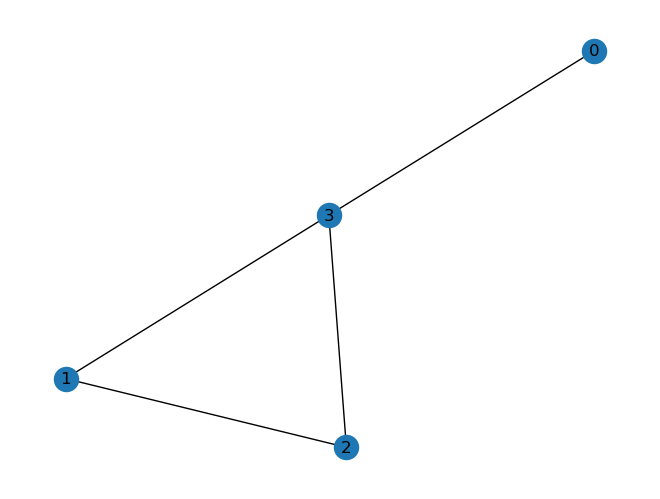

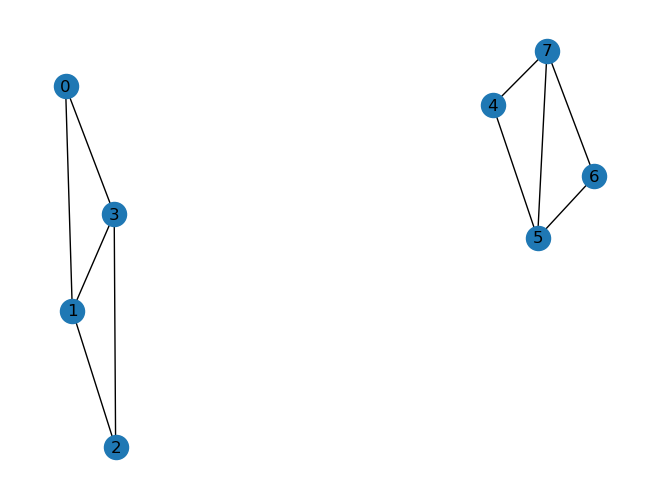

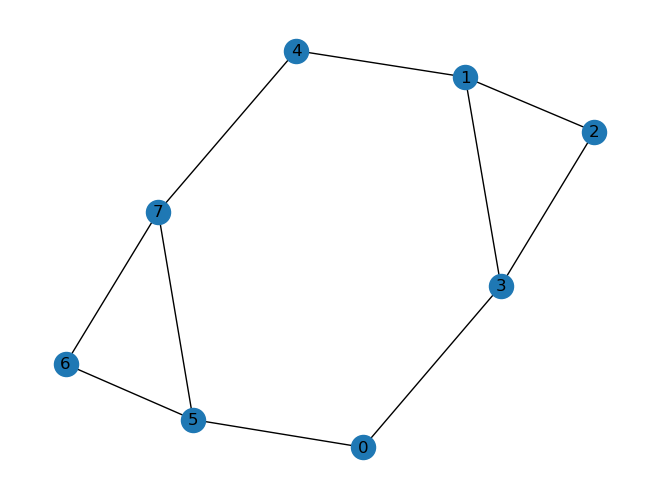

In [3]:
dataset_path = os.path.join(cwd, "data")
dataset_name = "targeted_attack_2_tailed_traingels"
motif_name = 'tailed_triangle'

tailed_trianlge = np.zeros((4,4))
tailed_trianlge[0,3] = 1
tailed_trianlge[1,2] = 1
tailed_trianlge[1,3] = 1
tailed_trianlge[2,3] = 1
g_p = nx.from_numpy_matrix(tailed_trianlge)
nx.draw(g_p, with_labels = True)
plt.show()


graph_1 = np.zeros((8,8))
graph_1[0:4,0:4] = tailed_trianlge
graph_1[4:,4:] = tailed_trianlge
graph_1[0,1] = 1
graph_1[4,5] = 1
graph_1 = nx.from_numpy_matrix(graph_1)
nx.draw(graph_1, with_labels = True)
plt.show()

graph_2 = np.zeros((8,8))
graph_2[0:4,0:4] = tailed_trianlge
graph_2[4:,4:] = tailed_trianlge
graph_2[0,5] = 1
graph_2[1,4] = 1
graph_2 = nx.from_numpy_matrix(graph_2)
nx.draw(graph_2, with_labels = True)
plt.show()

graphs = [graph_1, graph_2]
ground_truths = {motif_name: torch.tensor([subgraph_counting(graph, 'g43') for graph in graphs])}
dgl_graphs = [dgl.from_networkx(graph) for graph in graphs]
dgl.save_graphs(os.path.join(dataset_path, dataset_name + ".bin"), dgl_graphs, ground_truths)

In [4]:
# compute the counts with the models
model_path = os.path.join(cwd, "models/lrp/lrp0tailed_triangle_data1_1668436818.pkl")
#model_path = os.path.join(cwd, "models/lrp/lrp0tailed_triangle_data2_1668436821.pkl")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dataset = DglSyntheticDataset(dataset_name = dataset_name, dataset_path = dataset_path,task = motif_name, full_permutation = False)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_lrp_dgl_light)
hyperparam_list = {
        'lrp_length': 16,
        'num_tasks': 1,
        'lrp_in_dim': 1,
        'hid_dim': 128,
        'num_layers': 1,
        'bn': False,
        'lr': 0.001,
        'mlp': False
}
model = LRP_synthetic(
    num_tasks = hyperparam_list['num_tasks'],
    lrp_length = hyperparam_list['lrp_length'],
    lrp_in_dim = hyperparam_list['lrp_in_dim'],
    hid_dim = hyperparam_list['hid_dim'],
    num_layers = hyperparam_list['num_layers'],
    bn = hyperparam_list['bn'],
    mlp = hyperparam_list['mlp']
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
with torch.no_grad():
    for (batch, split_list, sp_matrices, label) in loader:
        batch = batch.to(device)
        batch.ndata['feat'] = torch.ones(batch.number_of_nodes(), 1).to(device)
        batch.edata['feat'] = torch.ones(batch.number_of_edges(), 1).to(device)
        mean_pooling_matrix = build_perm_pooling_sp_matrix(split_list, "mean").to(device)

        n_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[0]).to(device)
        e_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[1]).to(device)

        degs = batch.in_degrees(list(range(batch.number_of_nodes()))).type(torch.FloatTensor).to(device)

        pred = model(batch, mean_pooling_matrix, degs, n_to_perm_length_sp_matrix, e_to_perm_length_sp_matrix).item()
        predictions.append(pred)

print(f'\nGRAPH 1 results:')
print(f"\t- Ground truth: {ground_truths['tailed_triangle'][0].item()}")
print(f"\t- Prediction: {predictions[0]}\n")
print(f'GRAPH 2 results:')
print(f"\t- Ground truth: {ground_truths['tailed_triangle'][1].item()}")
print(f"\t- Prediction: {predictions[1]}")

Label variance:  4.0
Trying to load LRP!
LRP file does not exist!
Preprocessing LRP!


100%|██████████| 2/2 [00:00<00:00, 39.79it/s]

LRP generated with correct format
Saving LRP!
Saving LRP FINISHED!



GRAPH 1 results:
	- Ground truth: 0
	- Prediction: 0.06449878215789795

GRAPH 2 results:
	- Ground truth: 4
	- Prediction: 4.050171375274658


# Increase the number of substuctures

We try to increase the number of substructure in teh graphs to see how much does the predicted count differ form the ground truths.

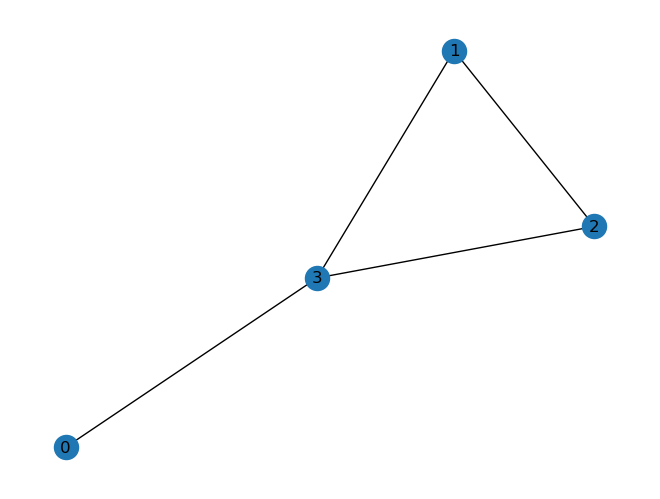

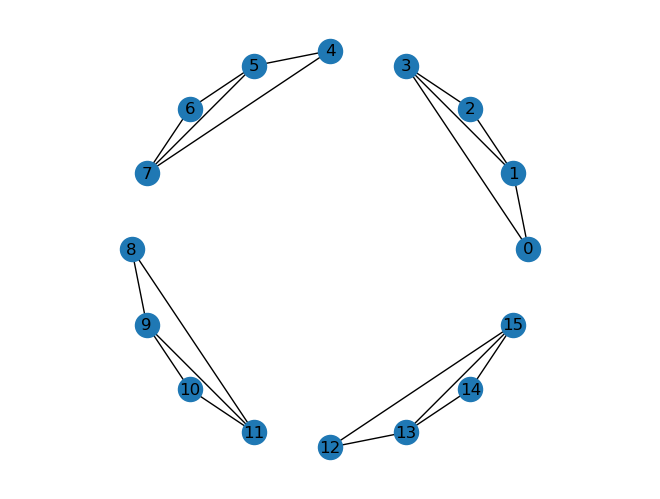

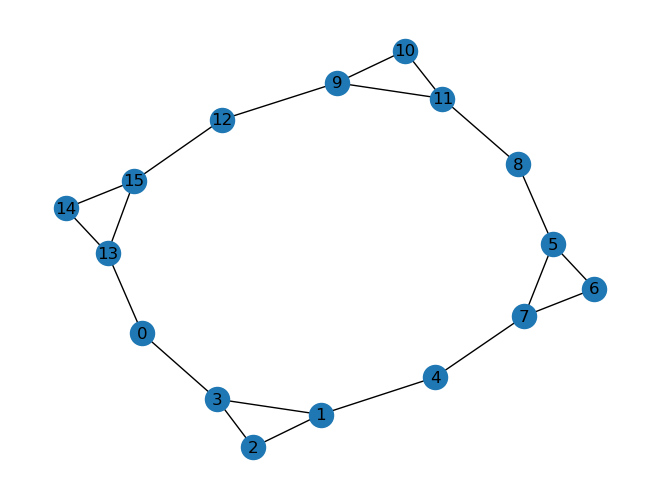

In [5]:
dataset_path = os.path.join(cwd, "data")
dataset_name = "targeted_attack_4_tailed_traingels"
motif_name = 'tailed_triangle'

tailed_trianlge = np.zeros((4,4))
tailed_trianlge[0,3] = 1
tailed_trianlge[1,2] = 1
tailed_trianlge[1,3] = 1
tailed_trianlge[2,3] = 1
g_p = nx.from_numpy_matrix(tailed_trianlge)
nx.draw(g_p, with_labels = True)
plt.show()


graph_1 = np.zeros((16,16))
graph_1[:4,:4] = tailed_trianlge
graph_1[4:8,4:8] = tailed_trianlge
graph_1[8:12,8:12] = tailed_trianlge
graph_1[12:,12:] = tailed_trianlge
graph_1[0,1] = 1
graph_1[4,5] = 1
graph_1[8,9] = 1
graph_1[12,13] = 1
graph_1 = nx.from_numpy_matrix(graph_1)
nx.draw_circular(graph_1, with_labels = True)
plt.axis('equal')
plt.show()

graph_2 = np.zeros((16,16))
graph_2[:4,:4] = tailed_trianlge
graph_2[4:8,4:8] = tailed_trianlge
graph_2[8:12,8:12] = tailed_trianlge
graph_2[12:,12:] = tailed_trianlge
graph_2[1,4] = 1
graph_2[5,8] = 1
graph_2[9,12] = 1
graph_2[13,0] = 1
graph_2 = nx.from_numpy_matrix(graph_2)
nx.draw(graph_2, with_labels = True)
plt.show()

graphs = [graph_1, graph_2]
ground_truths = {motif_name: torch.tensor([subgraph_counting(graph, 'g43') for graph in graphs])}
dgl_graphs = [dgl.from_networkx(graph) for graph in graphs]
dgl.save_graphs(os.path.join(dataset_path, dataset_name + ".bin"), dgl_graphs, ground_truths)

In [6]:
# compute the counts with the models
#model_path = os.path.join(cwd, "models/lrp/lrp0tailed_triangle_data1_1668436818.pkl")
model_path = os.path.join(cwd, "models/lrp/lrp0tailed_triangle_data2_1668436821.pkl")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dataset = DglSyntheticDataset(dataset_name = dataset_name, dataset_path = dataset_path,task = motif_name, full_permutation = False)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_lrp_dgl_light)
hyperparam_list = {
        'lrp_length': 16,
        'num_tasks': 1,
        'lrp_in_dim': 1,
        'hid_dim': 128,
        'num_layers': 1,
        'bn': False,
        'lr': 0.001,
        'mlp': False
}
model = LRP_synthetic(
    num_tasks = hyperparam_list['num_tasks'],
    lrp_length = hyperparam_list['lrp_length'],
    lrp_in_dim = hyperparam_list['lrp_in_dim'],
    hid_dim = hyperparam_list['hid_dim'],
    num_layers = hyperparam_list['num_layers'],
    bn = hyperparam_list['bn'],
    mlp = hyperparam_list['mlp']
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
with torch.no_grad():
    for (batch, split_list, sp_matrices, label) in loader:
        batch = batch.to(device)
        batch.ndata['feat'] = torch.ones(batch.number_of_nodes(), 1).to(device)
        batch.edata['feat'] = torch.ones(batch.number_of_edges(), 1).to(device)
        mean_pooling_matrix = build_perm_pooling_sp_matrix(split_list, "mean").to(device)

        n_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[0]).to(device)
        e_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[1]).to(device)

        degs = batch.in_degrees(list(range(batch.number_of_nodes()))).type(torch.FloatTensor).to(device)

        pred = model(batch, mean_pooling_matrix, degs, n_to_perm_length_sp_matrix, e_to_perm_length_sp_matrix).item()
        predictions.append(pred)

print(f'\nGRAPH 1 results:')
print(f"\t- Ground truth: {ground_truths['tailed_triangle'][0].item()}")
print(f"\t- Prediction: {predictions[0]}\n")
print(f'GRAPH 2 results:')
print(f"\t- Ground truth: {ground_truths['tailed_triangle'][1].item()}")
print(f"\t- Prediction: {predictions[1]}")

Label variance:  16.0
Trying to load LRP!
LRP file exists!
LRP file format correct!  16

GRAPH 1 results:
	- Ground truth: 0
	- Prediction: -0.026759345084428787

GRAPH 2 results:
	- Ground truth: 8
	- Prediction: 7.966124057769775
